# 1. Data Preprocessing and import libreries

## 1.1 Import required libreries

In [1]:
import numpy as np
from urllib import request
import random
import gzip
import pickle
import os
import matplotlib.pyplot as plt
import pandas as pd 
%matplotlib inline

## 1.2 Load mnist data

In [2]:
filename = [
["training_images","train-images-idx3-ubyte.gz"],
["test_images","t10k-images-idx3-ubyte.gz"],
["training_labels","train-labels-idx1-ubyte.gz"],
["test_labels","t10k-labels-idx1-ubyte.gz"]
]

In [3]:
def download_mnist():
    base_url = "http://yann.lecun.com/exdb/mnist/"
    for name in filename:
        print("Downloading "+name[1]+"...")
        request.urlretrieve(base_url+name[1], name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

def init():
    download_mnist()
    save_mnist()

def load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]
init()

Download complete.
Save complete.


In [4]:
def load_mnist(final=False, flatten=True):

    if not os.path.isfile('mnist.pkl'):
        init()

    xtrain, ytrain, xtest, ytest = load()
    xtl, xsl = xtrain.shape[0], xtest.shape[0]

    if flatten:
        xtrain = xtrain.reshape(xtl, -1)
        xtest  = xtest.reshape(xsl, -1)

    if not final: # return the flattened images
        return (xtrain[:-5000], ytrain[:-5000]), (xtrain[-5000:], ytrain[-5000:]), 10

    return (xtrain, ytrain), (xtest, ytest), 10

In [5]:
(x_train, t_train), (x_test,t_test), cls = load_mnist()

In [6]:
print(x_train.shape, t_train.shape)

(55000, 784) (55000,)


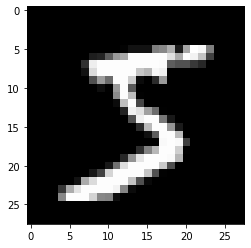

In [7]:
img = x_train[0,:].reshape(28,28) # First image in the training set.
plt.imshow(img,cmap='gray')
plt.show() # Show the image

## 1.3 data processing

### 1.3.1 Cover data to numpy array, convert to float and normalize by deviding 255 as gray sclase images will have 255 as the maximum value

In [8]:
x_train = np.array(x_train)
t_train = np.array(t_train)
x_test = np.array(x_test)
t_test = np.array(t_test)

In [9]:
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
x_train = x_train/255.
x_test = x_test/255.

In [10]:
x_train.shape

(55000, 784)

## 1.3.2 Output data processing by converting to one hot encoded data

In [11]:
def convertToOneHot(vector, num_classes=None):

    assert isinstance(vector, np.ndarray)
    assert len(vector) > 0

    if num_classes is None:
        num_classes = np.max(vector)+1
    else:
        assert num_classes > 0
        assert num_classes >= np.max(vector)

    result = np.zeros(shape=(len(vector), num_classes))
    result[np.arange(len(vector)), vector] = 1
    return result.astype(int)

t_train_hot = convertToOneHot(t_train)
t_test_hot = convertToOneHot(t_test)

In [12]:
t_train_hot.shape

(55000, 10)

[0 1 0 0 0 0 0 0 0 0]


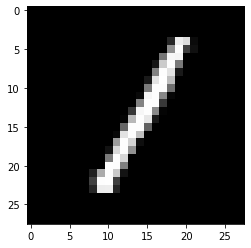

In [13]:
print(t_test_hot[0])
img = x_test[0,:].reshape(28,28)
plt.imshow(img, cmap='gray')
plt.show()

# 2. Building the network

In [14]:
# Activation Functions 
def sigmoid(inputs):
    return 1 / (1 + np.exp(-inputs))
def softmax(inputs):
    val = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
    return val/ np.sum(val, axis=1, keepdims=True)
# Loss function 
def log_loss(y_hat, y_target):
    y_hat = np.clip(y_hat, 1e-7, 1 - 1e-7)
    val = np.sum(y_hat * y_target,axis=1)
    return np.mean(-np.log(val))
# Gradient funcrtions for loss and activation 
def gradient_loss(y_hat, y_target):
    return y_hat - y_target
def gradient_sigmoid(layer, grads_in):
    return grads_in * layer.activation_output * (1 - layer.activation_output)
# Optimizer 
def optimizer(layer, lr):
    layer.weights = layer.weights -lr * layer.dw
    layer.biases = layer.biases -lr * layer.db
def mini_batch(X, y, batchSize):
	for i in np.arange(0, X.shape[0], batchSize):
		yield (X[i:i + batchSize], y[i:i + batchSize])

In [15]:
class layer():
    def __init__ (self, input_size, neuron_no):
        self.neuron_no = neuron_no
        self.weights = 0.1 * np.random.randn(input_size, neuron_no)
        self.biases = np.zeros((1, neuron_no))
    def forward_pass(self, inputs, activation = 'sigmoid'):
        self.inputs = inputs 
        self.outputs = np.dot(inputs, self.weights) + self.biases
        if activation == 'sigmoid': self.activation_output = sigmoid(self.outputs) 
        elif activation == 'softmax': self.activation_output = softmax(self.outputs)
    def backward_pass(self, grads_in):
        self.dw = np.dot(self.inputs.T, grads_in)
        self.db = np.sum(grads_in, axis=0, keepdims=True)
        self.grads = np.dot(grads_in, self.weights.T)

# 3 Experiments and results

## 3.1 Initail training with 20 epoches and lr=0.01

In [19]:
lr = 0.01 
epochs = 20
batch_size = 50
training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []

# Setting up the network 
input_layer = layer(neuron_no=300, input_size=784)
output_layer = layer(neuron_no=10, input_size=300)

for epoch in np.arange(0, epochs):
  trainLoss = []
  trainAcc = []
  valLoss = []
  valAcc = []
  for (miniX, miniY) in mini_batch(x_train, t_train_hot, batch_size):

    # Forward Pass
    input_layer.forward_pass(inputs=miniX, activation='sigmoid')
    output_layer.forward_pass(inputs=input_layer.activation_output, 
                             activation='softmax')
    # Calculate Loss 
    loss = log_loss(output_layer.activation_output, miniY)
    # loss = np.sum(err ** 2)
    trainLoss.append(loss)
    
    predictions = np.argmax(output_layer.activation_output, axis=1)
    if len(miniY.shape) == 2:
        y = np.argmax(miniY, axis=1)
    accuracy = np.mean(predictions==y)
    trainAcc.append(accuracy)

    # Backward pass 
    dL = gradient_loss(output_layer.activation_output, miniY)
    output_layer.backward_pass(dL)
    d_sig = gradient_sigmoid(input_layer, output_layer.grads)
    # print(d_sig)
    input_layer.backward_pass(d_sig)

    # update weights and biases 
    optimizer(input_layer, lr)
    optimizer(output_layer, lr)
  for (miniX, miniY) in mini_batch(x_test, t_test_hot, batch_size):

    # Forward Pass
    input_layer.forward_pass(inputs=miniX, activation='sigmoid')
    output_layer.forward_pass(inputs=input_layer.activation_output, 
                             activation='softmax')
    # Calculate Loss 
    loss = log_loss(output_layer.activation_output, miniY)
    # loss = np.sum(err ** 2)
    valLoss.append(loss)

    predictions = np.argmax(output_layer.activation_output, axis=1)
    if len(miniY.shape) == 2:
        y = np.argmax(miniY, axis=1)
    accuracy = np.mean(predictions==y)
    valAcc.append(accuracy)

  # print('epoch',epoch,'train loss:', np.average(trainLoss), "Val loss:", np.average(valLoss))
  print(f'epoch {epoch}, train loss: {np.average(trainLoss):.3f}, val loss:{np.average(valLoss):.3f}, train acc:{np.average(trainAcc):.3f}, val acc:{np.average(valAcc):.3f}')
  training_loss.append(np.average(trainLoss))
  validation_loss.append(np.average(valLoss))
  training_accuracy.append(np.average(trainAcc))
  validation_accuracy.append(np.average(valAcc))



epoch 0, train loss: 0.403, val loss:0.211, train acc:0.887, val acc:0.943
epoch 1, train loss: 0.206, val loss:0.151, train acc:0.940, val acc:0.959
epoch 2, train loss: 0.152, val loss:0.124, train acc:0.956, val acc:0.967
epoch 3, train loss: 0.120, val loss:0.109, train acc:0.965, val acc:0.971
epoch 4, train loss: 0.099, val loss:0.099, train acc:0.972, val acc:0.974
epoch 5, train loss: 0.083, val loss:0.092, train acc:0.976, val acc:0.977
epoch 6, train loss: 0.072, val loss:0.087, train acc:0.980, val acc:0.979
epoch 7, train loss: 0.062, val loss:0.082, train acc:0.982, val acc:0.979
epoch 8, train loss: 0.055, val loss:0.079, train acc:0.985, val acc:0.978
epoch 9, train loss: 0.048, val loss:0.077, train acc:0.987, val acc:0.978
epoch 10, train loss: 0.043, val loss:0.075, train acc:0.988, val acc:0.979
epoch 11, train loss: 0.038, val loss:0.073, train acc:0.990, val acc:0.979
epoch 12, train loss: 0.034, val loss:0.071, train acc:0.992, val acc:0.980
epoch 13, train loss: 

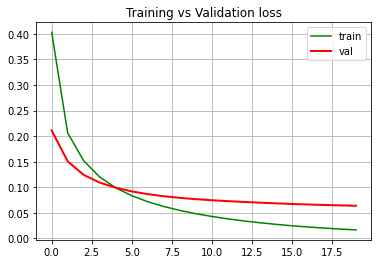

In [20]:
plt.title('Training vs Validation loss')
plt.plot(training_loss, color='g', label='train' )
plt.plot(validation_loss, linewidth=2, color='r', label='val')
plt.legend()
plt.grid()
plt.show()

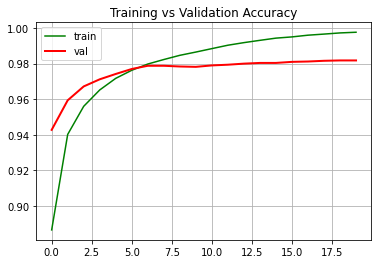

In [21]:
plt.title('Training vs Validation Accuracy')
plt.plot(training_accuracy,color='g', label='train')
plt.plot(validation_accuracy,linewidth=2, color='r', label='val')
plt.legend()
plt.grid()
plt.show()

## 3.2 Impact on loss and accurance for using SGD 

In [22]:
# Setting up the network 

iteration_no = 30

iter_loss_tr = []
iter_loss_val = []
iter_acc_tr = []
iter_acc_val = []
for i in range(iteration_no):
  input_layer = layer(neuron_no=300, input_size=784)
  output_layer = layer(neuron_no=10, input_size=300)

  lr = 0.01 
  epochs = 5
  batch_size = 50
  training_loss = []
  validation_loss = []
  training_accuracy = []
  validation_accuracy = []


  for epoch in np.arange(0, epochs):
    trainLoss = []
    trainAcc = []
    valLoss = []
    valAcc = []
    for (miniX, miniY) in mini_batch(x_train, t_train_hot, batch_size):

      # Forward Pass
      input_layer.forward_pass(inputs=miniX, activation='sigmoid')
      output_layer.forward_pass(inputs=input_layer.activation_output, 
                              activation='softmax')
      # Calculate Loss 
      loss = log_loss(output_layer.activation_output, miniY)
      # loss = np.sum(err ** 2)
      trainLoss.append(loss)
      
      predictions = np.argmax(output_layer.activation_output, axis=1)
      if len(miniY.shape) == 2:
          y = np.argmax(miniY, axis=1)
      accuracy = np.mean(predictions==y)
      trainAcc.append(accuracy)

      # Backward pass 
      dL = gradient_loss(output_layer.activation_output, miniY)
      output_layer.backward_pass(dL)
      d_sig = gradient_sigmoid(input_layer, output_layer.grads)
      # print(d_sig)
      input_layer.backward_pass(d_sig)

      # update weights and biases 
      optimizer(input_layer, lr)
      optimizer(output_layer, lr)
    for (miniX, miniY) in mini_batch(x_test, t_test_hot, batch_size):

      # Forward Pass
      input_layer.forward_pass(inputs=miniX, activation='sigmoid')
      output_layer.forward_pass(inputs=input_layer.activation_output, 
                              activation='softmax')
      # Calculate Loss 
      loss = log_loss(output_layer.activation_output, miniY)
      # loss = np.sum(err ** 2)
      valLoss.append(loss)

      predictions = np.argmax(output_layer.activation_output, axis=1)
      if len(miniY.shape) == 2:
          y = np.argmax(miniY, axis=1)
      accuracy = np.mean(predictions==y)
      valAcc.append(accuracy)

    # print('epoch',epoch,'train loss:', np.average(trainLoss), "Val loss:", np.average(valLoss))
    # print(f'epoch {epoch}, train loss: {np.average(trainLoss):.3f}, val loss:{np.average(valLoss):.3f}, train acc:{np.average(trainAcc):.3f}, val acc:{np.average(valAcc):.3f}')
    training_loss.append(np.average(trainLoss))
    validation_loss.append(np.average(valLoss))
    training_accuracy.append(np.average(trainAcc))
    validation_accuracy.append(np.average(valAcc))
  iter_loss_tr.append(np.average(training_loss))
  iter_loss_val.append(np.average(validation_loss))
  iter_acc_tr.append(np.average(training_accuracy))
  iter_acc_val.append(np.average(validation_accuracy))



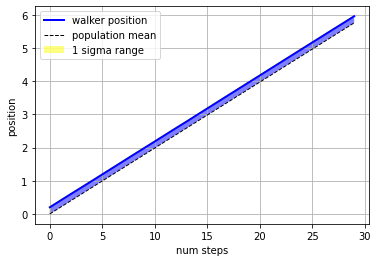

In [23]:
Nsteps = 30
from statistics import stdev

t = np.arange(Nsteps)

mu = np.average(iter_loss_tr)
sigma = stdev(iter_loss_tr)

# the steps and position
S = mu + sigma*np.random.randn(Nsteps)
X = S.cumsum()

# the 1 sigma upper and lower analytic population bounds
lower_bound = mu*t - sigma*np.sqrt(t)
upper_bound = mu*t + sigma*np.sqrt(t)

fig, ax = plt.subplots(1)
ax.plot(t, X, lw=2, label='walker position', color='blue')
ax.plot(t, mu*t, lw=1, label='population mean', color='black', ls='--')
ax.fill_between(t, lower_bound, upper_bound, facecolor='yellow', alpha=0.5,
                label='1 sigma range')
ax.legend(loc='upper left')

# here we use the where argument to only fill the region where the
# walker is above the population 1 sigma boundary
ax.fill_between(t, upper_bound, X, where=X > upper_bound, facecolor='blue',
                alpha=0.5)
ax.set_xlabel('num steps')
ax.set_ylabel('position')
ax.grid()


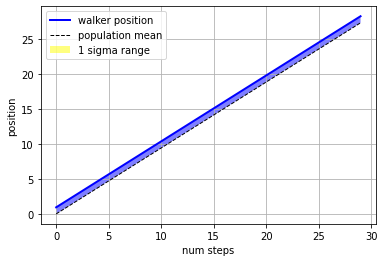

In [24]:
Nsteps = 30
from statistics import stdev

t = np.arange(Nsteps)

mu = np.average(iter_acc_tr)
sigma = stdev(iter_acc_tr)

# the steps and position
S = mu + sigma*np.random.randn(Nsteps)
X = S.cumsum()

# the 1 sigma upper and lower analytic population bounds
lower_bound = mu*t - sigma*np.sqrt(t)
upper_bound = mu*t + sigma*np.sqrt(t)

fig, ax = plt.subplots(1)
ax.plot(t, X, lw=2, label='walker position', color='blue')
ax.plot(t, mu*t, lw=1, label='population mean', color='black', ls='--')
ax.fill_between(t, lower_bound, upper_bound, facecolor='yellow', alpha=0.5,
                label='1 sigma range')
ax.legend(loc='upper left')

# here we use the where argument to only fill the region where the
# walker is above the population 1 sigma boundary
ax.fill_between(t, upper_bound, X, where=X > upper_bound, facecolor='blue',
                alpha=0.5)
ax.set_xlabel('num steps')
ax.set_ylabel('position')
ax.grid()


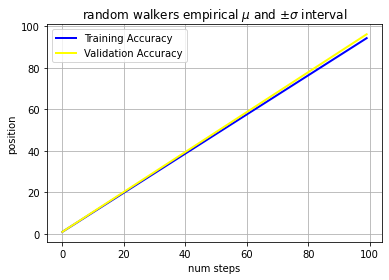

In [25]:
from statistics import stdev
Nsteps, Nwalkers = 100, 250
# nstesp = iteration_no, 
t = np.arange(Nsteps)

mu1 = np.average(iter_acc_tr)
mu2 = np.average(iter_acc_val)
sd1 = stdev(iter_acc_tr)
sd2 = stdev(iter_acc_val)

# an (Nsteps x Nwalkers) array of random walk steps
S1 = mu1 + sd1*np.random.randn(Nsteps, Nwalkers)
S2 = mu2 + sd2*np.random.randn(Nsteps, Nwalkers)

# an (Nsteps x Nwalkers) array of random walker positions
X1 = S1.cumsum(axis=0)
X2 = S2.cumsum(axis=0)


# Nsteps length arrays empirical means and standard deviations of both
# populations over time
mu1 = X1.mean(axis=1)
sigma1 = X1.std(axis=1)
mu2 = X2.mean(axis=1)
sigma2 = X2.std(axis=1)

# plot it!
fig, ax = plt.subplots(1)
ax.plot(t, mu1, lw=2, label='Training Accuracy', color='blue')
ax.plot(t, mu2, lw=2, label='Validation Accuracy', color='yellow')
ax.fill_between(t, mu1+sigma1, mu1-sigma1, facecolor='blue', alpha=0.5)
ax.fill_between(t, mu2+sigma2, mu2-sigma2, facecolor='yellow', alpha=0.5)
ax.set_title(r'random walkers empirical $\mu$ and $\pm \sigma$ interval')
ax.legend(loc='upper left')
ax.set_xlabel('num steps')
ax.set_ylabel('position')
ax.grid()

## 3.3 Different learning rates

In [167]:
# Setting up the network 

learning_rates = [0.0001, 0.01, 0.05]

iter_loss_tr = []
iter_loss_val = []
iter_acc_tr = []
iter_acc_val = []

for lr in learning_rates:
  input_layer = layer(neuron_no=300, input_size=784)
  output_layer = layer(neuron_no=10, input_size=300)

  # lr = 0.01 
  epochs = 5
  batch_size = 50
  training_loss = []
  validation_loss = []
  training_accuracy = []
  validation_accuracy = []


  for epoch in np.arange(0, epochs):
    trainLoss = []
    trainAcc = []
    valLoss = []
    valAcc = []
    for (miniX, miniY) in mini_batch(x_train, t_train_hot, batch_size):

      # Forward Pass
      input_layer.forward_pass(inputs=miniX, activation='sigmoid')
      output_layer.forward_pass(inputs=input_layer.activation_output, 
                              activation='softmax')
      # Calculate Loss 
      loss = log_loss(output_layer.activation_output, miniY)
      # loss = np.sum(err ** 2)
      trainLoss.append(loss)
      
      predictions = np.argmax(output_layer.activation_output, axis=1)
      if len(miniY.shape) == 2:
          y = np.argmax(miniY, axis=1)
      accuracy = np.mean(predictions==y)
      trainAcc.append(accuracy)

      # Backward pass 
      dL = gradient_loss(output_layer.activation_output, miniY)
      output_layer.backward_pass(dL)
      d_sig = gradient_sigmoid(input_layer, output_layer.grads)
      # print(d_sig)
      input_layer.backward_pass(d_sig)

      # update weights and biases 
      optimizer(input_layer, lr)
      optimizer(output_layer, lr)
    for (miniX, miniY) in mini_batch(x_test, t_test_hot, batch_size):

      # Forward Pass
      input_layer.forward_pass(inputs=miniX, activation='sigmoid')
      output_layer.forward_pass(inputs=input_layer.activation_output, 
                              activation='softmax')
      # Calculate Loss 
      loss = log_loss(output_layer.activation_output, miniY)
      # loss = np.sum(err ** 2)
      valLoss.append(loss)

      predictions = np.argmax(output_layer.activation_output, axis=1)
      if len(miniY.shape) == 2:
          y = np.argmax(miniY, axis=1)
      accuracy = np.mean(predictions==y)
      valAcc.append(accuracy)

    # print('epoch',epoch,'train loss:', np.average(trainLoss), "Val loss:", np.average(valLoss))
    # print(f'epoch {epoch}, train loss: {np.average(trainLoss):.3f}, val loss:{np.average(valLoss):.3f}, train acc:{np.average(trainAcc):.3f}, val acc:{np.average(valAcc):.3f}')
    training_loss.append(np.average(trainLoss))
    validation_loss.append(np.average(valLoss))
    training_accuracy.append(np.average(trainAcc))
    validation_accuracy.append(np.average(valAcc))
  iter_loss_tr.append(training_loss)
  iter_loss_val.append(validation_loss)
  iter_acc_tr.append(training_accuracy)
  iter_acc_val.append(validation_accuracy)

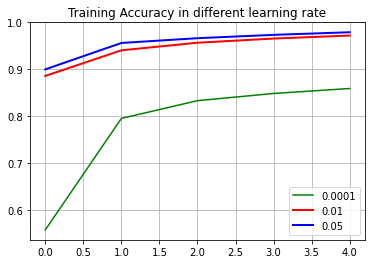

In [176]:
plt.title('Training Accuracy in different learning rate')
plt.plot(iter_acc_tr[0], color='g', label='0.0001' )
plt.plot(iter_acc_tr[1], linewidth=2, color='r', label='0.01')
plt.plot(iter_acc_tr[2], linewidth=2, color='b', label='0.05')
plt.legend()
plt.grid()
plt.show()

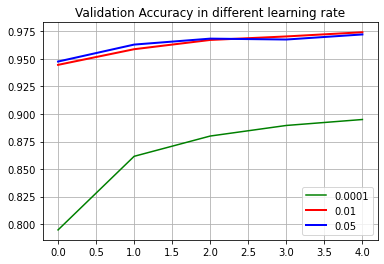

In [175]:
plt.title('Validation Accuracy in different learning rate')
plt.plot(iter_acc_val[0], color='g', label='0.0001' )
plt.plot(iter_acc_val[1], linewidth=2, color='r', label='0.01')
plt.plot(iter_acc_val[2], linewidth=2, color='b', label='0.05')
plt.legend()
plt.grid()
plt.show()

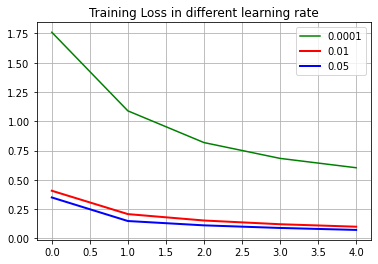

In [174]:
plt.title('Training Loss in different learning rate')
plt.plot(iter_loss_tr[0], color='g', label='0.0001' )
plt.plot(iter_loss_tr[1], linewidth=2, color='r', label='0.01')
plt.plot(iter_loss_tr[2], linewidth=2, color='b', label='0.05')
plt.legend()
plt.grid()
plt.show()

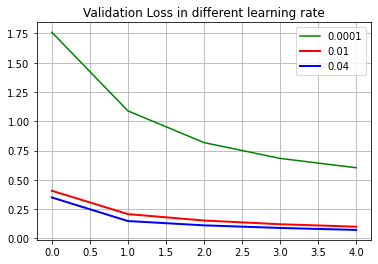

In [171]:
plt.title('Validation Loss in different learning rate')
plt.plot(iter_loss_tr[0], color='g', label='0.0001' )
plt.plot(iter_loss_tr[1], linewidth=2, color='r', label='0.01')
plt.plot(iter_loss_tr[2], linewidth=2, color='b', label='0.04')
plt.legend()
plt.grid()
plt.show()

## 3.4 Final run

In [177]:
def load_mnist(final=True, flatten=True):

    if not os.path.isfile('mnist.pkl'):
        init()

    xtrain, ytrain, xtest, ytest = load()
    xtl, xsl = xtrain.shape[0], xtest.shape[0]

    if flatten:
        xtrain = xtrain.reshape(xtl, -1)
        xtest  = xtest.reshape(xsl, -1)

    if not final: # return the flattened images
        return (xtrain[:-5000], ytrain[:-5000]), (xtrain[-5000:], ytrain[-5000:]), 10

    return (xtrain, ytrain), (xtest, ytest), 10

(x_train, t_train), (x_test,t_test), cls = load_mnist()
x_train = np.array(x_train)
t_train = np.array(t_train)
x_test = np.array(x_test)
t_test = np.array(t_test)
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
x_train = x_train/255.
x_test = x_test/255.
t_train_hot = convertToOneHot(t_train)
t_test_hot = convertToOneHot(t_test)


In [183]:
t_train_hot.shape

(60000, 10)

In [178]:
lr = 0.01 
epochs = 10
batch_size = 50
training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []

# Setting up the network 
input_layer = layer(neuron_no=300, input_size=784)
output_layer = layer(neuron_no=10, input_size=300)

for epoch in np.arange(0, epochs):
  trainLoss = []
  trainAcc = []
  valLoss = []
  valAcc = []
  for (miniX, miniY) in mini_batch(x_train, t_train_hot, batch_size):

    # Forward Pass
    input_layer.forward_pass(inputs=miniX, activation='sigmoid')
    output_layer.forward_pass(inputs=input_layer.activation_output, 
                             activation='softmax')
    # Calculate Loss 
    loss = log_loss(output_layer.activation_output, miniY)
    # loss = np.sum(err ** 2)
    trainLoss.append(loss)
    
    predictions = np.argmax(output_layer.activation_output, axis=1)
    if len(miniY.shape) == 2:
        y = np.argmax(miniY, axis=1)
    accuracy = np.mean(predictions==y)
    trainAcc.append(accuracy)

    # Backward pass 
    dL = gradient_loss(output_layer.activation_output, miniY)
    output_layer.backward_pass(dL)
    d_sig = gradient_sigmoid(input_layer, output_layer.grads)
    # print(d_sig)
    input_layer.backward_pass(d_sig)

    # update weights and biases 
    optimizer(input_layer, lr)
    optimizer(output_layer, lr)
  for (miniX, miniY) in mini_batch(x_test, t_test_hot, batch_size):

    # Forward Pass
    input_layer.forward_pass(inputs=miniX, activation='sigmoid')
    output_layer.forward_pass(inputs=input_layer.activation_output, 
                             activation='softmax')
    # Calculate Loss 
    loss = log_loss(output_layer.activation_output, miniY)
    # loss = np.sum(err ** 2)
    valLoss.append(loss)

    predictions = np.argmax(output_layer.activation_output, axis=1)
    if len(miniY.shape) == 2:
        y = np.argmax(miniY, axis=1)
    accuracy = np.mean(predictions==y)
    valAcc.append(accuracy)

  # print('epoch',epoch,'train loss:', np.average(trainLoss), "Val loss:", np.average(valLoss))
  print(f'epoch {epoch}, train loss: {np.average(trainLoss):.3f}, val loss:{np.average(valLoss):.3f}, train acc:{np.average(trainAcc):.3f}, val acc:{np.average(valAcc):.3f}')
  training_loss.append(np.average(trainLoss))
  validation_loss.append(np.average(valLoss))
  training_accuracy.append(np.average(trainAcc))
  validation_accuracy.append(np.average(valAcc))



epoch 0, train loss: 0.388, val loss:0.251, train acc:0.889, val acc:0.926
epoch 1, train loss: 0.204, val loss:0.183, train acc:0.941, val acc:0.945
epoch 2, train loss: 0.150, val loss:0.143, train acc:0.957, val acc:0.957
epoch 3, train loss: 0.117, val loss:0.120, train acc:0.966, val acc:0.965
epoch 4, train loss: 0.096, val loss:0.105, train acc:0.972, val acc:0.968
epoch 5, train loss: 0.080, val loss:0.095, train acc:0.977, val acc:0.970
epoch 6, train loss: 0.069, val loss:0.088, train acc:0.981, val acc:0.973
epoch 7, train loss: 0.060, val loss:0.083, train acc:0.984, val acc:0.974
epoch 8, train loss: 0.052, val loss:0.079, train acc:0.986, val acc:0.975
epoch 9, train loss: 0.046, val loss:0.076, train acc:0.988, val acc:0.975


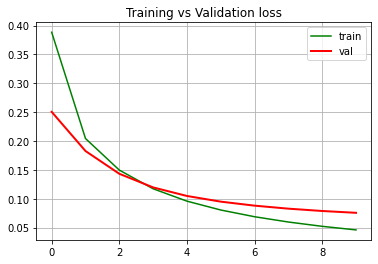

In [179]:
plt.title('Training vs Validation loss')
plt.plot(training_loss, color='g', label='train' )
plt.plot(validation_loss, linewidth=2, color='r', label='val')
plt.legend()
plt.grid()
plt.show()

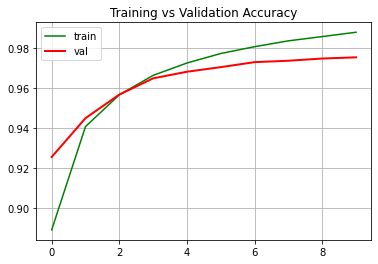

In [180]:
plt.title('Training vs Validation Accuracy')
plt.plot(training_accuracy,color='g', label='train')
plt.plot(validation_accuracy,linewidth=2, color='r', label='val')
plt.legend()
plt.grid()
plt.show()